# AC variability
The demo for 

In [1]:
# set env
# set root dir,
#root_dir = '/Users/fiona/OneDrive - mail.bnu.edu.cn/Project/Prediction/Article'
root_dir = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference'
import pandas as pd
from pylab import text
from scipy.stats import entropy
from scipy.stats import ttest_rel
from scipy import interpolate
import scipy.io as sio
import scipy.stats
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import mannwhitneyu, normaltest
import seaborn as sns
import joypy
# from pcntoolkit.normative import estimate, evaluate
# from pcntoolkit.util.utils import create_bspline_basis, compute_MSLL
from scipy import interpolate
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import re

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
#from bioinfokit.analys import stat # post hoc
# boxplot with sig

script_path = root_dir + '/Code'

if not os.path.exists(script_path):
    script_path = '/data/disk2/luojunhao/Project/PT_HG_PR/PT_Individualized_Prediction/Prediction/dsPrediction/Prediction/Pipeline'
    print('Work platform: gonglab server')
else:
    print('Work platform: luojunjao MAC')

sys.path.append(script_path + '/utility')
sys.path.append(script_path + '/utility/io_')
import plot_
import io_

# 及时清除notebook输出，防止文件太大打不开或者后续编辑卡顿
from IPython.display import clear_output

# scipy.stats.ttest_rel(df['LPAC_MeanSM_tMean'], df['RPAC_MeanSM_tMean']) 配对t检验
#tstat, pval = stats.ttest_ind(ps1, ps2, alternative="two-sided") 双样本t检验

# save df as a png
import dataframe_image as dfi
# dfi.export(T, "T.png")

Work platform: luojunjao MAC


## View the brain maps

In [12]:
def view_clusters(lpac_data, rpac_data, save_name):

    ## 1. plot surf
    import matplotlib.colors as mcolors
    #my_colors = ['black', 'red', 'yellow', 'green','blue']
    #my_colors = ['blue', 'green', 'yellow', 'red','black']
    my_colors = ['blue', 'green', 'yellow','red']
    my_cmap = mcolors.ListedColormap(my_colors, name="my_cmap")
    from surfplot import Plot
    from neuromaps.datasets import fetch_fslr
    surfaces = fetch_fslr()
    #lh, rh = surfaces['inflated']
    lh, rh = surfaces['sphere']
    lh1, rh1 = surfaces['veryinflated']

    # build
    pac = Plot(surf_lh=lh, surf_rh=rh, views = 'lateral',size = (500,250),zoom = 1.5, brightness = 0.6)
    pac1 = Plot(surf_lh=lh1, surf_rh=rh1, views = 'lateral',size = (500,200),zoom = 1.5, brightness = 0.6)
    #fig = pac.build()
    #fig.show()
    ## 2.add overlay
    #fig, axs = plt.subplots(2, 1)
    pac.add_layer({'left': lpac_data, 'right': rpac_data}, cmap = my_cmap, cbar = False, zero_transparent = True, as_outline = False)
    pac1.add_layer({'left': lpac_data, 'right': rpac_data}, cmap = my_cmap, cbar = False, zero_transparent = True, as_outline = False)
    fig = pac.build()
    fig1 = pac1.build()
    #fig = pac1.build()
    #pac.colorbar(fig, extend='min', extendrect=True)
    fig.show()
    fig1.show()


    #save_dir = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/Manuscript/Figs/Fig4'
#     if not os.path.exists(save_dir):
#         os.mkdir(save_dir)
    fig1.savefig(save_name, facecolor='white', dpi=1000) # background color: white
    plt.close()

    #fig1.savefig(save_dir +

## 1. Spectral Clustering vs. HCPMMP

### AC union mask

In [5]:
hemis = ['left', 'right']
# pac mask
lmask = sio.loadmat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/RAW/PAC_Union_mask/lpac_union_mask.mat')
rmask = sio.loadmat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/RAW/PAC_Union_mask/rpac_union_mask.mat')
lmask_val = lmask['lpac_union_mask'][0,:]
lmask_val.shape
rmask_val = rmask['rpac_union_mask'][0,:]
rmask_val.shape

(32492,)

### HCP-MMP AC mask (4-rois)
- label 1: R1
- label 2: A1
- label 3: Belt (M_Belt + L_Belt)
- label 4: Pbelt

In [6]:

hmmp_lpac = sio.loadmat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/hcpmmp_4ac/left_ac_4rois.mat')
hmmp_lpac = hmmp_lpac['l_ac']
hmmp_lpac = hmmp_lpac[:,0]

hmmp_rpac = sio.loadmat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/hcpmmp_4ac/right_ac_4rois.mat')
hmmp_rpac = hmmp_rpac['r_ac']
hmmp_rpac = hmmp_rpac[:,0]

hmmp_lpac = hmmp_lpac.astype(float)
hmmp_rpac = hmmp_rpac.astype(float)

# # overlap
# np.sum(np.logical_and(lmask_val, hmmp_lpac)) # overlap
# np.sum(np.logical_and(rmask_val, hmmp_rpac)) #  overlap

In [114]:
hmmp_lpac.shape

(32492,)

### Clustering ROIs  (4-rois)
- label 1: ROI 1
- label 2: ROI 2
- label 3: ROI 3
- label 4: ROI 4

In [4]:
# left
clu_lpac = sio.loadmat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/check_hand/cluster4_32k_left_refresh_relabel.mat')
clu_lpac = clu_lpac['clu_l_ac']
clu_lpac = clu_lpac[0,:]
# right
clu_rpac = sio.loadmat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/check_hand/cluster4_32k_right_refresh_relabel.mat')
clu_rpac = clu_rpac['clu_r_ac']
clu_rpac = clu_rpac[0,:]

### Dice Between clustering rois and hcpmmp-rois

In [7]:
# creat Dices func
def dice(arr1, arr2):
    a = np.where(arr1!=0)[0]
    b = np.where(arr2!=0)[0]
    ind = np.intersect1d(a,b)

    dice_ = 2*len(ind)/(len(a) + len(b))
    print(dice_)
    return dice_

In [45]:
# left
dices = []

roi_mask = clu_lpac.copy()
label = 4
roi_mask[roi_mask != label] = 0;

for i in np.arange(4):
    h_label = i + 1
    h_mask = hmmp_lpac.copy()
    h_mask[h_mask != h_label] = 0
    
    hc_dice = dice(roi_mask, h_mask)
    dices.append(hc_dice)
    
    





0.0
0.0
0.0
0.0603448275862069


In [49]:
# right
dices = []

roi_mask = clu_rpac.copy()
label = 4
roi_mask[roi_mask != label] = 0;

for i in np.arange(4):
    h_label = i + 1
    h_mask = hmmp_rpac.copy()
    h_mask[h_mask != h_label] = 0
    
    hc_dice = dice(roi_mask, h_mask)
    dices.append(hc_dice)
    

0.0728476821192053
0.0
0.0
0.1125


### View the original and refershed clusters, as well as the hcpmmp

/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/3912098074.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/3912098074.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


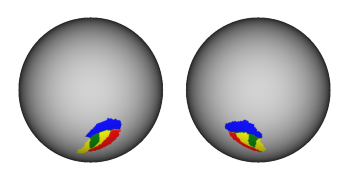

In [134]:


file_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/check_hand/cluster4_32k_left_refresh.mat'
file_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/check_hand/cluster4_32k_right_refresh.mat'
left = sio.loadmat(file_l)
right = sio.loadmat(file_r)
# #     labels_l = left['Clustering_labels'][0,:]
# #     labels_r = right['Clustering_labels'][0,:]
# #     vert_index_l = df_l_opt['vert_matlab'] -1 
# #     vert_index_r = df_r_opt['vert_matlab'] -1 
# lpac_data = left['lpac_data'][0,:]
# rpac_data = right['rpac_data'][0,:]

lpac_data = hmmp_lpac
rpac_data = hmmp_rpac

# lpac_data = left['cluster_left_refresh'][0,:]
# rpac_data = right['cluster_right_refresh'][0,:]


# #view and save fig

save_dir = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/figs'
save_name = save_dir + '/' + 'clustering-hcpmmp_4rois-inflated.png'
view_clusters(lpac_data, rpac_data, save_name)

In [130]:
left

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Aug 23 11:09:50 2023',
 '__version__': '1.0',
 '__globals__': [],
 'cluster_left_refresh': array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

# 2. The robustness of the clustering

In [6]:
## The optminal AC mask
df_l_opt = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/df_left_thr0.1_stats.csv')
df_r_opt = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/df_right_thr0.1_stats.csv')


### Similarity matrix

In [7]:
## left
l_variability = df_l_opt['l_variability']
n = len(l_variability)
l_sim = np.zeros((len(l_variability),len(l_variability) ))

for k, val in enumerate(l_variability):
    tmp = np.array([val]*n)
    l_sim[k, :] = abs(tmp - l_variability)
l_sim = 1 - l_sim

## right

r_variability = df_r_opt['r_variability']
n = len(r_variability)
r_sim = np.zeros((len(r_variability),len(r_variability) ))

for k, val in enumerate(r_variability):
    tmp = np.array([val]*n)
    r_sim[k, :] = abs(tmp - r_variability)
r_sim = 1 - r_sim

### Clustering

In [8]:

from sklearn import cluster, metrics

def LJH_SpectralClustering(InputMatrix,OutFile,ClassNum=2): # default class=2
    clustering = SpectralClustering(n_clusters=ClassNum,assign_labels="discretize",random_state=0).fit(InputMatrix)
    clustering.labels_
    #scio.savemat('/Users/Junhao/data/Project/Clustering/result/LPT_LHS_pos_clustering_label_2type.mat',{'Clustering_labels':clustering.labels_+1})
    sio.savemat(OutFile,{'Clustering_labels':clustering.labels_+1}) # plus 1 for matlab index
    return  clustering.labels_+1



def LJH_SpectralClustering_fit(InputMatrix,OutFile,ClassNum, rand_seed, Gamma): # default class=2
    optimal_gamma=[0.001]
    max_CH_Score=0 # initial CH-SCORE
    optimal_n_cluster=2
    #ClassNum:tuple
    #for Gamma in optimal_gamma:
   

    gamma=Gamma
    for k in ClassNum:
        clustering = cluster.SpectralClustering(n_clusters=k,gamma=Gamma,assign_labels="discretize",random_state=0).fit(InputMatrix)
        clustering.labels_
        score=metrics.calinski_harabasz_score(InputMatrix,clustering.labels_)

        print ("Calinski-Harabaz Score with gamma=", gamma, "n_clusters=", k,"score:", score)
        #scio.savemat('/Users/Junhao/data/Project/Clustering/result/LPT_LHS_pos_clustering_label_2type.mat',{'Clustering_labels':clustering.labels_+1})
        #sio.savemat(OutFile,{'Clustering_labels':clustering.labels_+1}) # plus 1 for matlab index
        if score>max_CH_Score:
           max_CH_Score=score
           optimal_gamma=gamma
           optimal_n_cluster=k
    optimal_params=dict(gamma=optimal_gamma,n_cluster=optimal_n_cluster,CH_score=max_CH_Score)
    
    opt_clustering= cluster.SpectralClustering(n_clusters=optimal_n_cluster,gamma=optimal_gamma,assign_labels="discretize",random_state=rand_seed).fit(InputMatrix)
          
    sio.savemat(OutFile,{'Clustering_labels':opt_clustering.labels_+1,'OptParams':optimal_params}) # plus 1 for
    
    return  optimal_params,opt_clustering.labels_+1



## Different rand seeds (gamma = 0.001)

In [119]:
## the results in the paper.
n_class = [4]
Gamma = 0.001
rand_seeds = np.arange(0,1000,5)

for rand_seed in rand_seeds:

    out_file_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/left/cluster_4_left' + '_' + 'rand_seed_' + str(rand_seed) + '.mat'
    paras_l, labels_l = LJH_SpectralClustering_fit(l_sim,out_file_l,n_class, rand_seed, Gamma)
    print(paras_l)
    out_file_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/right/cluster_4_right' + '_' + 'rand_seed_' + str(rand_seed) + '.mat'
    paras_r, labels_r = LJH_SpectralClustering_fit(r_sim,out_file_r,n_class, rand_seed, Gamma)
    print(paras_r)

/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}


In [54]:
rand_seed = np.arange(0,100,5)

In [55]:
rand_seed

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95])

## View the results

### Orig-view

In [14]:
## file orig-view

rand_seeds = np.arange(0,1000,5)
Gamma = 0.001
for rand_seed in rand_seeds:

    file_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/orig_clustering/left/cluster_4_left_rand_seed_' + str(rand_seed) + '.mat'
    file_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/orig_clustering/right/cluster_4_right_rand_seed_' + str(rand_seed) + '.mat'
    left = sio.loadmat(file_l)
    right = sio.loadmat(file_r)
    labels_l = left['Clustering_labels'][0,:]
    labels_r = right['Clustering_labels'][0,:]
    vert_index_l = df_l_opt['vert_matlab'] -1 
    vert_index_r = df_r_opt['vert_matlab'] -1 
    lpac_data = np.zeros((32492,))
    rpac_data = np.zeros((32492,))
    lpac_data[vert_index_l] = labels_l
    rpac_data[vert_index_r] = labels_r
    
    # save 32k files
    save_32k_l = file_l.replace('orig_clustering', 'orig_clustering_32k')
    save_32k_r = file_r.replace('orig_clustering', 'orig_clustering_32k')
    
    sio.savemat(save_32k_l, {'lpac_data': lpac_data})
    sio.savemat(save_32k_r, {'rpac_data': rpac_data})
    
       
    # view and save fig

#     save_dir = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/figs'
#     save_name = save_dir + '/' + 'custers_lr_rand_seed_' + str(rand_seed) + '.png'
#     view_clusters(lpac_data, rpac_data, save_name)

### Orig-corrected view

/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/i

/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/surfplot/plotting.py:515: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:29: UserWa

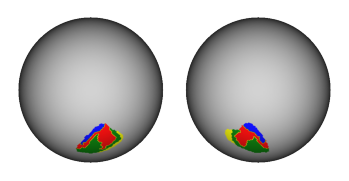

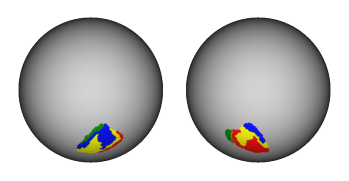

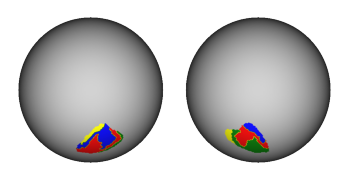

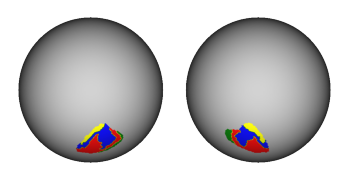

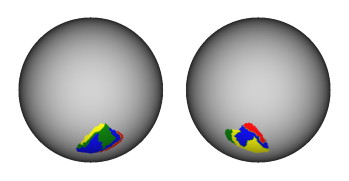

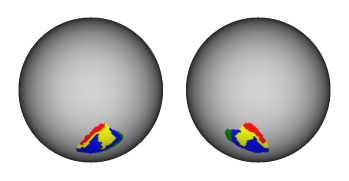

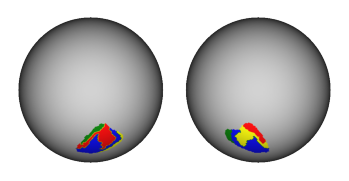

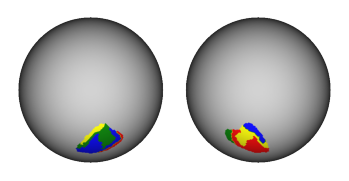

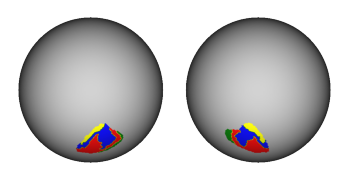

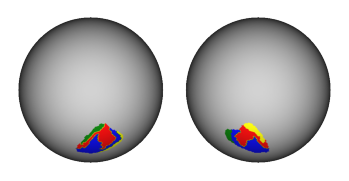

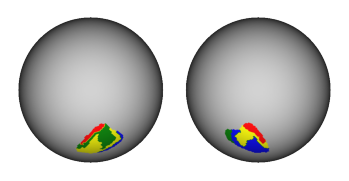

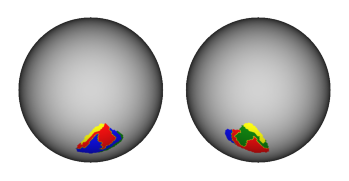

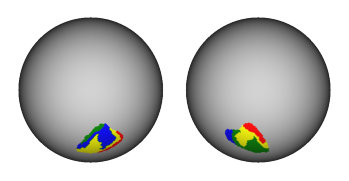

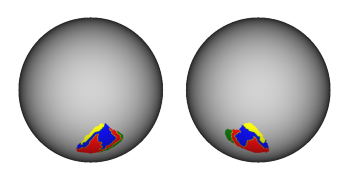

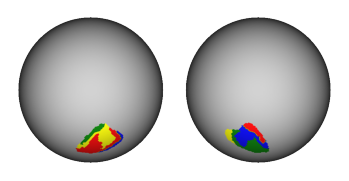

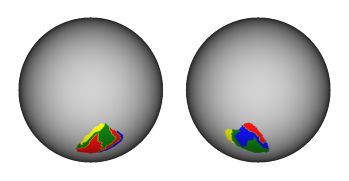

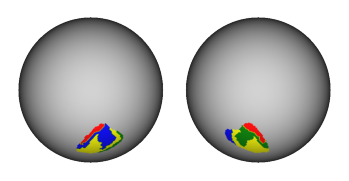

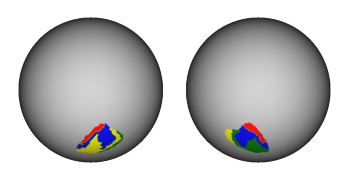

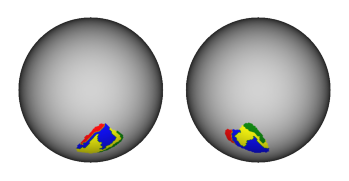

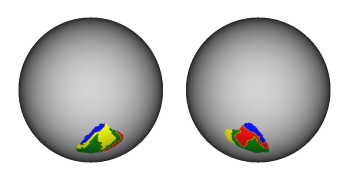

In [22]:
## file orig-view

rand_seeds = np.arange(0,100,5)
Gamma = 0.001
for rand_seed in rand_seeds:

    file_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/orig_clustering_32k_corrected/left/cluster_4_left_rand_seed_' + str(rand_seed) + '.mat'
    file_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/orig_clustering_32k_corrected/right/cluster_4_right_rand_seed_' + str(rand_seed) + '.mat'
    left = sio.loadmat(file_l)
    right = sio.loadmat(file_r)
#     labels_l = left['Clustering_labels'][0,:]
#     labels_r = right['Clustering_labels'][0,:]
#     vert_index_l = df_l_opt['vert_matlab'] -1 
#     vert_index_r = df_r_opt['vert_matlab'] -1 
    lpac_data = left['clus'][:,0]
    rpac_data = right['clus'][:,0]
#     lpac_data[vert_index_l] = labels_l
#     rpac_data[vert_index_r] = labels_r
    
    # save 32k files
#     save_32k_l = file_l.replace('orig_clustering', 'orig_clustering_32k')
#     save_32k_r = file_r.replace('orig_clustering', 'orig_clustering_32k')
    
#     sio.savemat(save_32k_l, {'lpac_data': lpac_data})
#     sio.savemat(save_32k_r, {'rpac_data': rpac_data})
    
       
    #view and save fig

    save_dir = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/orig_clustering_32k_corrected/figs'
    save_name = save_dir + '/' + 'custers_lr_rand_seed_' + str(rand_seed) + '.png'
    view_clusters(lpac_data, rpac_data, save_name)

### Orig-corrected-labels view (rand 0 as a ref)

/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/i

/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/surfplot/plotting.py:515: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_39217/1738768917.py:29: UserWa

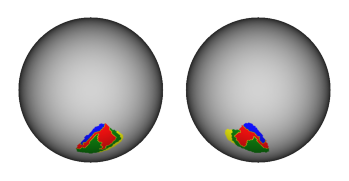

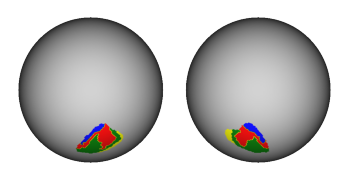

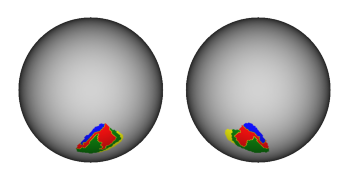

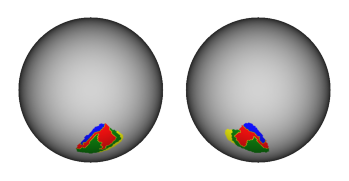

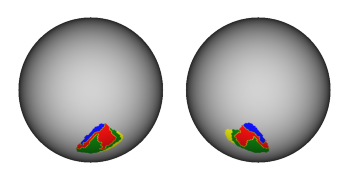

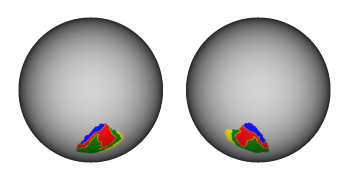

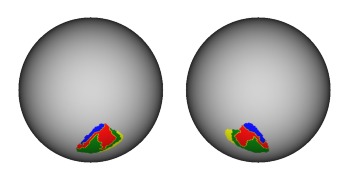

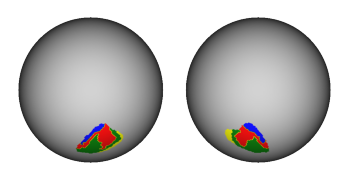

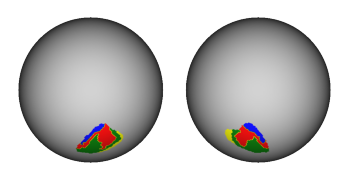

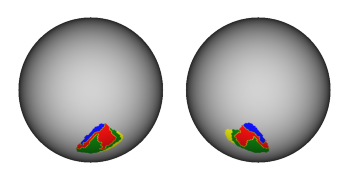

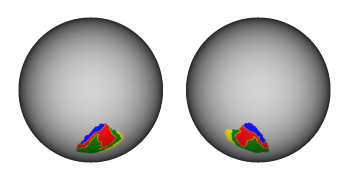

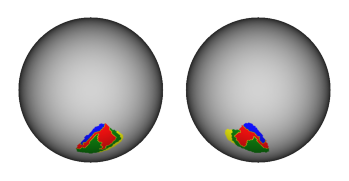

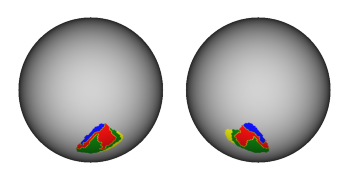

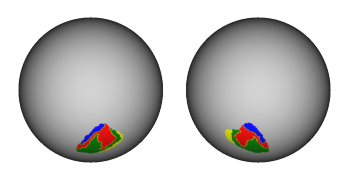

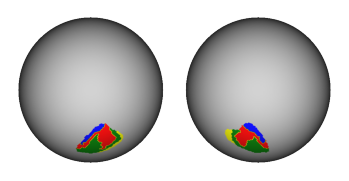

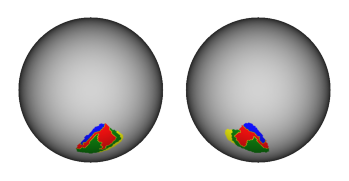

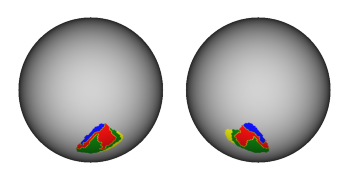

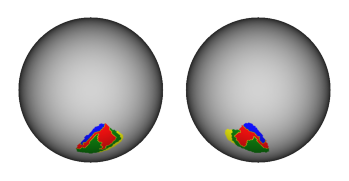

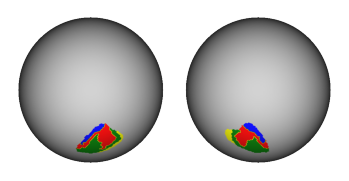

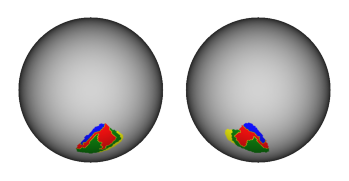

In [25]:
## file orig-view

rand_seeds = np.arange(0,100,5)
Gamma = 0.001
for rand_seed in rand_seeds:

    file_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_e-3_ref_rand0_corrected/left/cluster_4_left_rand_seed_' + str(rand_seed) + '.mat'
    file_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_e-3_ref_rand0_corrected/right/cluster_4_right_rand_seed_' + str(rand_seed) + '.mat'
    left = sio.loadmat(file_l)
    right = sio.loadmat(file_r)
#     labels_l = left['Clustering_labels'][0,:]
#     labels_r = right['Clustering_labels'][0,:]
#     vert_index_l = df_l_opt['vert_matlab'] -1 
#     vert_index_r = df_r_opt['vert_matlab'] -1 
    lpac_data = left['clus'][:,0]
    rpac_data = right['clus'][:,0]
#     lpac_data[vert_index_l] = labels_l
#     rpac_data[vert_index_r] = labels_r
    
    # save 32k files
#     save_32k_l = file_l.replace('orig_clustering', 'orig_clustering_32k')
#     save_32k_r = file_r.replace('orig_clustering', 'orig_clustering_32k')
    
#     sio.savemat(save_32k_l, {'lpac_data': lpac_data})
#     sio.savemat(save_32k_r, {'rpac_data': rpac_data})
    
       
    #view and save fig

    save_dir = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_e-3_ref_rand0_corrected/figs'
    save_name = save_dir + '/' + 'custers_lr_rand_seed_' + str(rand_seed) + '.png'
    view_clusters(lpac_data, rpac_data, save_name)

In [21]:
left['clus'][:,0].shape

(32492,)

In [70]:
left['Clustering_labels'][0,:].shape

(677,)

In [116]:
np.arange(0,1000,5).shape

(200,)

## Different gamma (rand seed = 0)

In [78]:
n_class = [4]
#Gamma = 0.001
rand_seed = 0
Gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for Gamma in Gammas:

    out_file_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/cluster_4_left' + '_' + 'gamma_' + str(Gamma) + '.mat'
    paras_l, labels_l = LJH_SpectralClustering_fit(l_sim,out_file_l,n_class, rand_seed, Gamma)
    print(paras_l)
    out_file_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/cluster_4_right' + '_' + 'gamma_' + str(Gamma) + '.mat'
    paras_r, labels_r = LJH_SpectralClustering_fit(r_sim,out_file_r,n_class, rand_seed, Gamma)
    print(paras_r)

/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 1e-05 n_clusters= 4 score: 951.0180108034973
{'gamma': 1e-05, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 1e-05 n_clusters= 4 score: 953.9280308161843
{'gamma': 1e-05, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.0001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.0001, 'n_cluster': 4, 'CH_score': 951.0180108034973}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

Calinski-Harabaz Score with gamma= 0.0001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.0001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 951.0180108034973
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 951.0180108034973}
Calinski-Harabaz Score with gamma= 0.001 n_clusters= 4 score: 953.9280308161843
{'gamma': 0.001, 'n_cluster': 4, 'CH_score': 953.9280308161843}
Calinski-Harabaz Score with gamma= 0.01 n_clusters= 4 score: 957.6259740818696
{'gamma': 0.01, 'n_cluster': 4, 'CH_score': 957.6259740818696}
Calinski-Harabaz Score with gamma= 0.01 n_clusters= 4 score: 965.8945353088325


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

{'gamma': 0.01, 'n_cluster': 4, 'CH_score': 965.8945353088325}
Calinski-Harabaz Score with gamma= 0.1 n_clusters= 4 score: 951.6411677328158


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.1, 'n_cluster': 4, 'CH_score': 951.6411677328158}
Calinski-Harabaz Score with gamma= 0.1 n_clusters= 4 score: 970.1916526467786


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 0.1, 'n_cluster': 4, 'CH_score': 970.1916526467786}
Calinski-Harabaz Score with gamma= 1 n_clusters= 4 score: 609.2179598215259


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 1, 'n_cluster': 4, 'CH_score': 609.2179598215259}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 1 n_clusters= 4 score: 768.6121386593663
{'gamma': 1, 'n_cluster': 4, 'CH_score': 768.6121386593663}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 10 n_clusters= 4 score: 619.6309280376006


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 10, 'n_cluster': 4, 'CH_score': 619.6309280376006}
Calinski-Harabaz Score with gamma= 10 n_clusters= 4 score: 663.5633109409142


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 10, 'n_cluster': 4, 'CH_score': 663.5633109409142}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 100 n_clusters= 4 score: 586.0664055236035


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 100, 'n_cluster': 4, 'CH_score': 586.0664055236035}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 100 n_clusters= 4 score: 808.7224824666577


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 100, 'n_cluster': 4, 'CH_score': 808.7224824666577}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 1000 n_clusters= 4 score: 47.496254273545595


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 1000, 'n_cluster': 4, 'CH_score': 47.496254273545595}


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Calinski-Harabaz Score with gamma= 1000 n_clusters= 4 score: 663.5294079386742


/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


{'gamma': 1000, 'n_cluster': 4, 'CH_score': 663.5294079386742}


/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_63652/3912098074.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_63652/3912098074.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_63652/3912098074.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_63652/3912098074.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/i

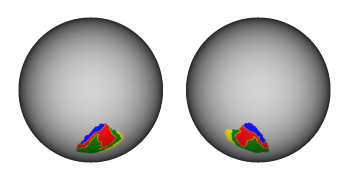

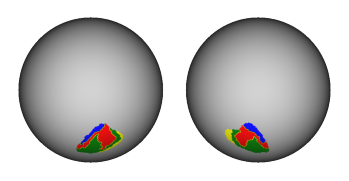

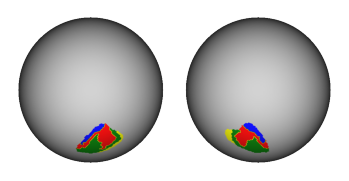

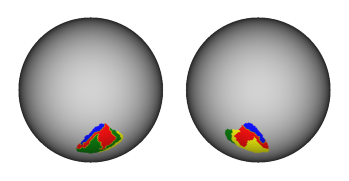

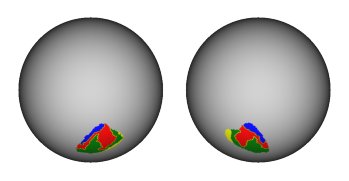

In [9]:
## view

#Gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1] # gammas with high chs.

df_chs_l = pd.DataFrame(columns=['gamma','chs'])
df_chs_r = pd.DataFrame(columns=['gamma','chs'])
for k, Gamma in enumerate(Gammas):


    file_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/high_chs_32k_corrected/cluster_4_left' + '_' + 'gamma_' + str(Gamma) + '.mat'
    file_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0//high_chs_32k_corrected/cluster_4_right' + '_' + 'gamma_' + str(Gamma) + '.mat'
    left = sio.loadmat(file_l)
    right = sio.loadmat(file_r)
    lpac_data = left['clus'][:,0]
    rpac_data = right['clus'][:,0]
    
    # ch-score
#     ch_l = left['OptParams']['CH_score'][0][0][0][0]
#     ch_r = right['OptParams']['CH_score'][0][0][0][0]
#     df_chs_l.loc[k, 'gamma'] = Gamma
#     df_chs_l.loc[k, 'chs'] = ch_l
#     df_chs_r.loc[k, 'gamma'] = Gamma
#     df_chs_r.loc[k, 'chs'] = ch_r
    

    save_dir = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/high_chs_32k_corrected/figs'
    save_name = save_dir + '/' + 'custers_lr_gamma_' + str(Gamma) + '.png'
    view_clusters(lpac_data, rpac_data, save_name)

    # save as 32k
#     save_dir_l = file_l.replace('gamma_rand0', 'gamma_rand0/high_chs_32k')
#     save_dir_r = file_r.replace('gamma_rand0', 'gamma_rand0/high_chs_32k')
#     sio.savemat(save_dir_l,{'lpac_data': lpac_data})
#     sio.savemat(save_dir_r,{'rpac_data': rpac_data})
    
    
    

/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_63652/3912098074.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_63652/3912098074.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_63652/3912098074.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/ipykernel_63652/3912098074.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/1n/npkftymd515bm5b0123vj3cm0000gn/T/i

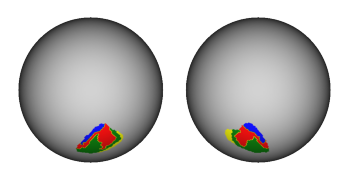

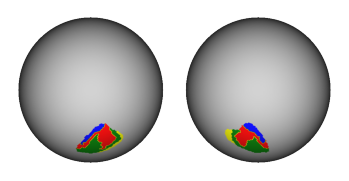

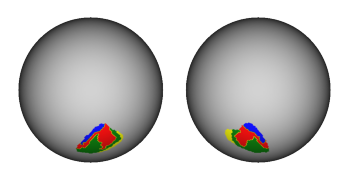

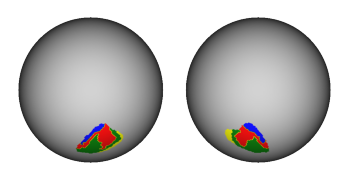

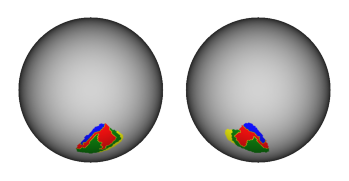

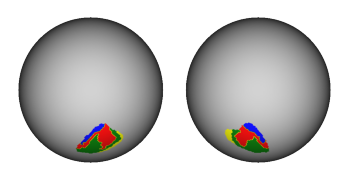

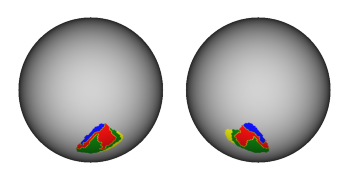

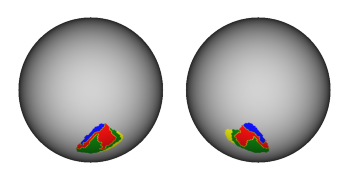

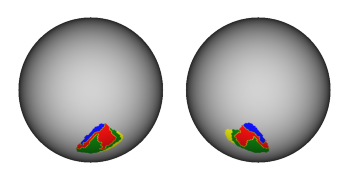

In [27]:
## view- ref gamma 0.001

Gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
#Gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1] # gammas with high chs.

df_chs_l = pd.DataFrame(columns=['gamma','chs'])
df_chs_r = pd.DataFrame(columns=['gamma','chs'])
for k, Gamma in enumerate(Gammas):


    file_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/cluster_4_left' + '_' + 'gamma_' + str(Gamma) + '.mat'
    file_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/cluster_4_right' + '_' + 'gamma_' + str(Gamma) + '.mat'
    left = sio.loadmat(file_l)
    right = sio.loadmat(file_r)
    #lpac_data = left['clus'][:,0]
    #rpac_data = right['clus'][:,0]
    
    # ch-score
    ch_l = left['OptParams']['CH_score'][0][0][0][0]
    ch_r = right['OptParams']['CH_score'][0][0][0][0]
    df_chs_l.loc[k, 'gamma'] = Gamma
    df_chs_l.loc[k, 'chs'] = ch_l
    df_chs_r.loc[k, 'gamma'] = Gamma
    df_chs_r.loc[k, 'chs'] = ch_r
    

    save_dir = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/high_chs_corrected_ref_gamma_e-3/figs'
    save_name = save_dir + '/' + 'custers_lr_gamma_' + str(Gamma) + '.png'
    view_clusters(lpac_data, rpac_data, save_name)

    # save as 32k
#     save_dir_l = file_l.replace('gamma_rand0', 'gamma_rand0/high_chs_32k')
#     save_dir_r = file_r.replace('gamma_rand0', 'gamma_rand0/high_chs_32k')
#     sio.savemat(save_dir_l,{'lpac_data': lpac_data})
#     sio.savemat(save_dir_r,{'rpac_data': rpac_data})
    
    
    

In [19]:
left


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Dec  4 14:13:47 2023',
 '__version__': '1.0',
 '__globals__': [],
 'clus': array([[-0.],
        [-0.],
        [-0.],
        ...,
        [-0.],
        [-0.],
        [-0.]])}

In [22]:
Gamma

1e-05

In [28]:
df_chs_r

gamma         chs
0  0.00001  953.928031
1   0.0001  953.928031
2    0.001  953.928031
3     0.01  965.894535
4      0.1  970.191653
5        1  768.612139
6       10  663.563311
7      100  808.722482
8     1000  663.529408

In [29]:
df_chs = 0.5*(df_chs_l + df_chs_r)


### rand-seed 0, CH scores

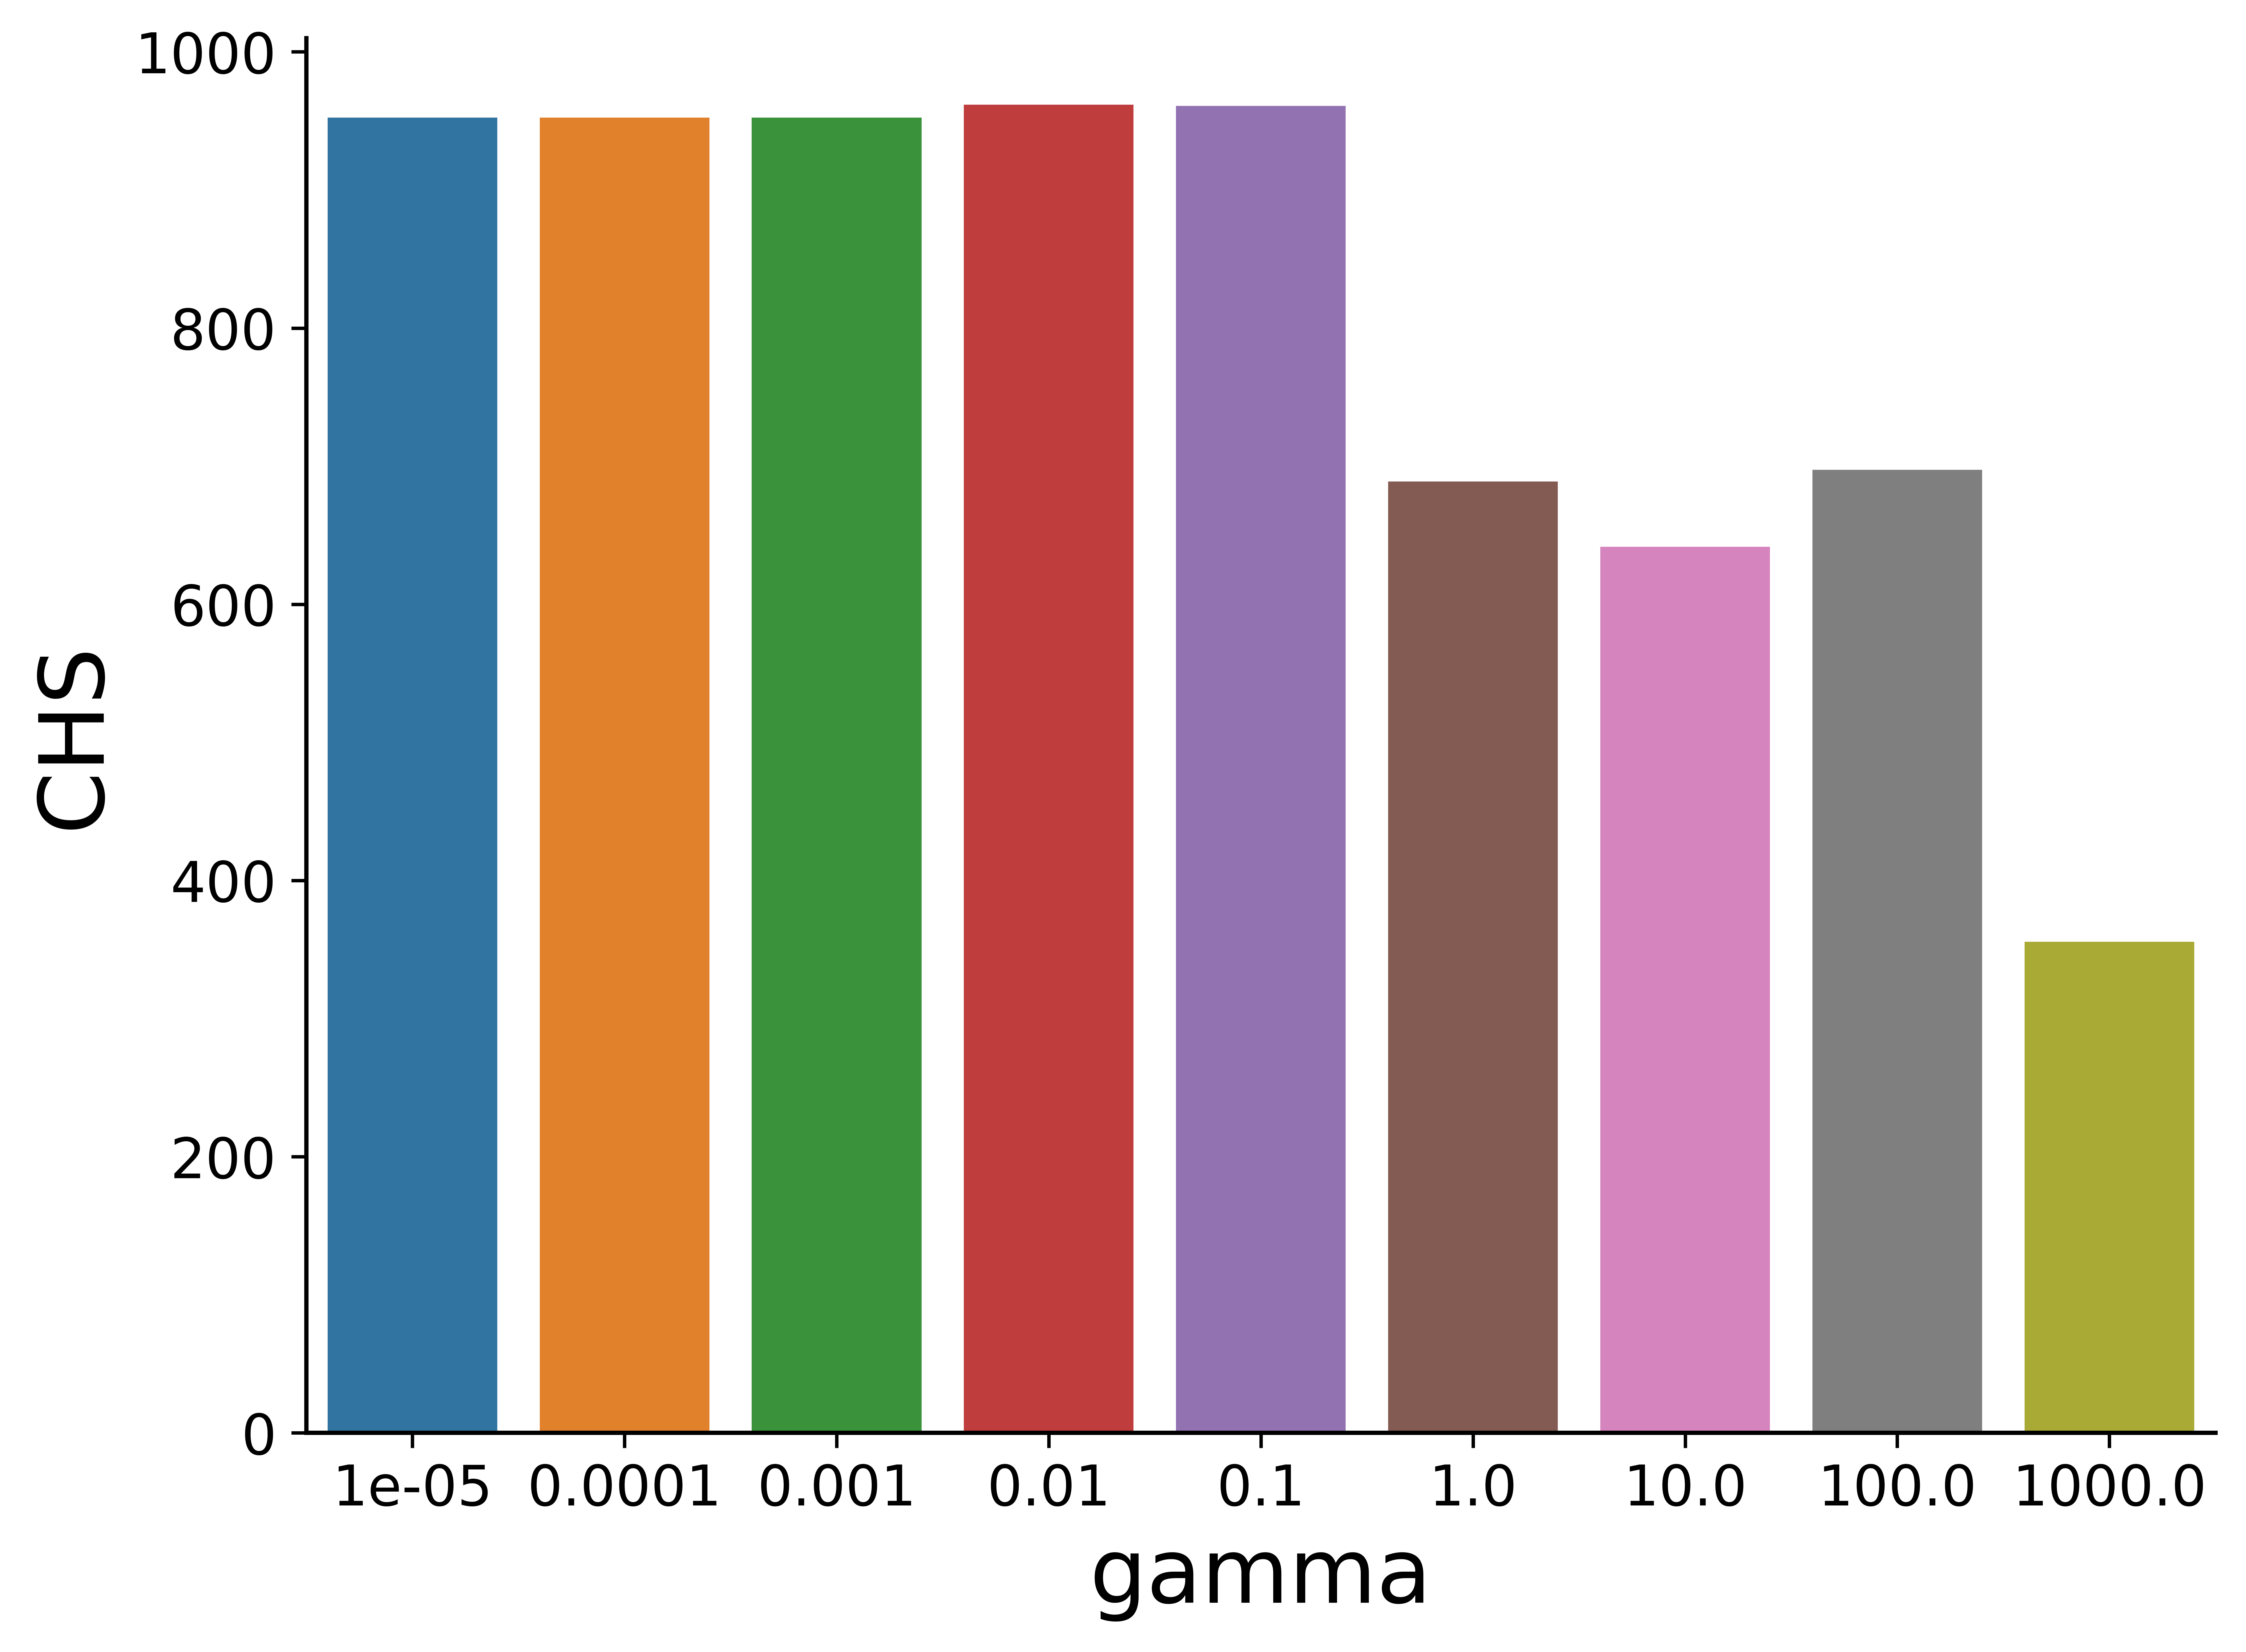

In [39]:
#sns.color_palette("Spectral", as_cmap=True)

#sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

fig, ax  = plt.subplots(figsize=(8,6), dpi=1000)
sns.barplot(x = 'gamma', y = 'chs', data = df_chs)

ax.set_xlabel("gamma", fontsize = 21)
ax.set_ylabel("CHS", fontsize = 21)
# change the xticks
ax.spines[['right', 'top']].set_visible(False)
ax.spines['bottom'].set_linewidth(1.0);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(1.0);####设置左边坐标轴的粗细
#plt.rcParams['ytick.labelsize']= 10 # set y_tick font size
plt.rcParams['ytick.labelsize']= 13
plt.rcParams['xtick.labelsize']= 13
plt.show()

fig.savefig('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/Manuscript/CC/Supp/FigS1/raw/rand-seed0_gammas_ch-scores.pdf',dpi=1000, facecolor='white')

#### view brain map with high chs

In [98]:
#### 

#Gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1] # gammas with high chs.

df_chs_l = pd.DataFrame(columns=['gamma','chs'])
df_chs_r = pd.DataFrame(columns=['gamma','chs'])
for k, Gamma in enumerate(Gammas):


    file_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/cluster_4_left' + '_' + 'gamma_' + str(Gamma) + '.mat'
    file_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/cluster_4_right' + '_' + 'gamma_' + str(Gamma) + '.mat'
    left = sio.loadmat(file_l)
    right = sio.loadmat(file_r)
    labels_l = left['Clustering_labels'][0,:]
    labels_r = right['Clustering_labels'][0,:]
    vert_index_l = df_l_opt['vert_matlab'] -1 
    vert_index_r = df_r_opt['vert_matlab'] -1 
    lpac_data = np.zeros((32492,))
    rpac_data = np.zeros((32492,))
    lpac_data[vert_index_l] = labels_l
    rpac_data[vert_index_r] = labels_r
    
    # ch-score
#     ch_l = left['OptParams']['CH_score'][0][0][0][0]
#     ch_r = right['OptParams']['CH_score'][0][0][0][0]
#     df_chs_l.loc[k, 'gamma'] = Gamma
#     df_chs_l.loc[k, 'chs'] = ch_l
#     df_chs_r.loc[k, 'gamma'] = Gamma
#     df_chs_r.loc[k, 'chs'] = ch_r
    

#     save_dir = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/c_vs_hcpmmp/robust/gamma_rand0/figs'
#     save_name = save_dir + '/' + 'custers_lr_gamma_' + str(Gamma) + '.png'
#     view_clusters(lpac_data, rpac_data, save_name)

#     # save as 32k
#     save_dir_l = file_l.replace('gamma_rand0', 'gamma_rand0/high_chs_32k')
#     save_dir_r = file_r.replace('gamma_rand0', 'gamma_rand0/high_chs_32k')
#     sio.savemat(save_dir_l,{'lpac_data': lpac_data})
#     sio.savemat(save_dir_r,{'rpac_data': rpac_data})
    

Help on function barplot in module seaborn.categorical:

barplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean at 0x1082e4700>, ci=95, n_boot=1000, units=None, seed=None, orient=None, color=None, palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, dodge=True, ax=None, **kwargs)
    Show point estimates and confidence intervals as rectangular bars.
    
    A bar plot represents an estimate of central tendency for a numeric
    variable with the height of each rectangle and provides some indication of
    the uncertainty around that estimate using error bars. Bar plots include 0
    in the quantitative axis range, and they are a good choice when 0 is a
    meaningful value for the quantitative variable, and you want to make
    comparisons against it.
    
    For datasets where 0 is not a meaningful value, a point plot will allow you
    to focus on differences between levels of one or more categorical
    variables

## 3. Decoding

In [41]:
## left
l_c1 = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/neurosynth_decoding/left_c1_blue_decoding_Top100.csv')
l_c2 = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/neurosynth_decoding/left_c2_green_decoding_Top100.csv')
l_c3 = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/neurosynth_decoding/left_c3_yellow_decoding_Top100.csv')
l_c4 = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/neurosynth_decoding/left_c4_red_decoding_Top100.csv')


## right
r_c1 = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/neurosynth_decoding/right_c1_blue_decoding_Top100.csv')
r_c2 = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/neurosynth_decoding/right_c2_green_decoding_Top100.csv')
r_c3 = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/neurosynth_decoding/right_c3_yellow_decoding_Top100.csv')
r_c4 = pd.read_csv('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/stats/clustering/neurosynth_decoding/right_c4_red_decoding_Top100.csv')




In [42]:
### top-30
lt_c1 = l_c1.iloc[0:30]
lt_c2 = l_c2.iloc[0:30]
lt_c3 = l_c3.iloc[0:30]
lt_c4 = l_c4.iloc[0:30]

rt_c1 = r_c1.iloc[0:30]
rt_c2 = r_c2.iloc[0:30]
rt_c3 = r_c3.iloc[0:30]
rt_c4 = r_c4.iloc[0:30]

# terms names, union
lt_c1_name = set(lt_c1['feature'])
lt_c2_name = set(lt_c2['feature'])
lt_c3_name = set(lt_c3['feature'])
lt_c4_name = set(lt_c4['feature'])

rt_c1_name = set(rt_c1['feature'])
rt_c2_name = set(rt_c2['feature'])
rt_c3_name = set(rt_c3['feature'])
rt_c4_name = set(rt_c4['feature'])

## all term names
terms_all = lt_c1_name | lt_c2_name | lt_c3_name | lt_c4_name | rt_c1_name | rt_c2_name | rt_c3_name | rt_c4_name
terms = list(terms_all)

In [43]:
# statistical: sum of left and right r
df_term = pd.DataFrame(columns = ['terms', 'sum_r'])
df_term['terms'] = terms

sums = []

for k, term in enumerate(terms):
    
    # left
    
    if term in lt_c1_name:
        lt_c1_r = lt_c1[lt_c1['feature'] == term]['r'].to_numpy()[0]
    else:
        lt_c1_r = 0
        
    if term in lt_c2_name:
        lt_c2_r = lt_c2[lt_c2['feature'] == term]['r'].to_numpy()[0]
    else:
        lt_c2_r = 0
        
    if term in lt_c3_name:
        lt_c3_r = lt_c3[lt_c3['feature'] == term]['r'].to_numpy()[0]
    else:
        lt_c3_r = 0
        
    if term in lt_c4_name:
        lt_c4_r = lt_c4[lt_c4['feature'] == term]['r'].to_numpy()[0]
        
    else:
        lt_c4_r = 0
        
  
    
    # right
    if term in rt_c1_name:
        rt_c1_r = rt_c1[rt_c1['feature'] == term]['r'].to_numpy()[0]
    else:
        rt_c1_r = 0
        
    if term in rt_c2_name:
        rt_c2_r = rt_c2[rt_c2['feature'] == term]['r'].to_numpy()[0]
    else:
        rt_c2_r = 0
        
    if term in rt_c3_name:
        rt_c3_r = rt_c3[rt_c3['feature'] == term]['r'].to_numpy()[0]
    else:
        rt_c3_r = 0
        
    if term in rt_c4_name:
        rt_c4_r = rt_c4[rt_c4['feature'] == term]['r'].to_numpy()[0]
        
    else:
        rt_c4_r = 0
        
    
    sum_r =  lt_c1_r + lt_c2_r + lt_c3_r + lt_c3_r + rt_c1_r + rt_c2_r + rt_c3_r + rt_c3_r
    
    print('sum_r: ', sum_r)
    
    sums.append(sum_r)
    
# restore
df_term['sum_r'] = sums
    
    
 
        
        
  
   
        
    
   
        
    
   


   
        
    
    
    
    
    
    
    
    

sum_r:  0.8874652838266754
sum_r:  0.0379111930678547
sum_r:  0.4664652735366174
sum_r:  0
sum_r:  1.7869527534677645
sum_r:  0.0345017309408553
sum_r:  0.173892898638632
sum_r:  0.1179225774032266
sum_r:  1.202179585560981
sum_r:  0.3691394752433013
sum_r:  0.7561723303700824
sum_r:  0.0451176403230942
sum_r:  0.0488913781577065
sum_r:  0.2673659811738424
sum_r:  0.186618883943211
sum_r:  0.0420536979058466
sum_r:  0.4835698126099583
sum_r:  0.0457695376392401
sum_r:  0.0392681830899883
sum_r:  0.0834351148806068
sum_r:  0.09124910138100939
sum_r:  0.1228917619026327
sum_r:  0.7929556267444542
sum_r:  0.6977007618942336
sum_r:  0
sum_r:  0.324416222346168
sum_r:  0.08219553972636309
sum_r:  0.20965846262615628
sum_r:  0.903742319006996
sum_r:  0.0504983326459357
sum_r:  0.44991832627307893
sum_r:  0.2717291699568042
sum_r:  0.7470531399001655
sum_r:  0.7601163165085575
sum_r:  0.9100870888470167
sum_r:  0.0487514377672565
sum_r:  0.5668405312938184
sum_r:  0.6821650015110015
sum_r:  1

In [44]:
ss = lt_c1_name | lt_c2_name

In [71]:
s = lt_c1[lt_c1['feature'] == terms[1]]['r'].to_numpy()[0]


In [45]:
df_term

terms     sum_r
0          temporale  0.887465
1     insular cortex  0.037911
2              vocal  0.466465
3    visual auditory  0.000000
4           auditory  1.786953
..               ...       ...
57           primary  0.297213
58             tones  0.373073
59        electrical  0.038653
60     cortex insula  0.037773
61  planum temporale  0.887465

[62 rows x 2 columns]

In [46]:
df_m = pd.melt(df_term, id_vars=['sum_r'], value_vars=['terms'])
df_m

sum_r variable             value
0   0.887465    terms         temporale
1   0.037911    terms    insular cortex
2   0.466465    terms             vocal
3   0.000000    terms   visual auditory
4   1.786953    terms          auditory
..       ...      ...               ...
57  0.297213    terms           primary
58  0.373073    terms             tones
59  0.038653    terms        electrical
60  0.037773    terms     cortex insula
61  0.887465    terms  planum temporale

[62 rows x 3 columns]

In [47]:
df = df_m.sort_values(by="sum_r", ascending=False)
df

sum_r variable                   value
4   1.786953    terms                auditory
38  1.217990    terms         auditory cortex
8   1.202180    terms       superior temporal
56  1.143129    terms                  speech
55  1.061879    terms                  sounds
..       ...      ...                     ...
60  0.037773    terms           cortex insula
45  0.037047    terms    cortical subcortical
5   0.034502    terms                  muscle
3   0.000000    terms         visual auditory
24  0.000000    terms  somatosensory cortices

[62 rows x 3 columns]

In [57]:
fig, ax  = plt.subplots(figsize=(10,20), dpi=1000)

sns.barplot(y= 'value', x = 'sum_r', data = df, order = df['value'], orient='h')

# 设置order参数：按重要程度（importance）从大到小输出的结果:
#sns.barplot(x="importance", y="feature", data=df, order=df["feature"], orient="h")
ax.set_xlabel("Sum of the correlations", fontsize = 21)
ax.set_ylabel("The union set of the top 30 decoding terms", fontsize = 21)
# change the xticks
ax.spines[['right', 'top']].set_visible(False)
ax.spines['bottom'].set_linewidth(1.0);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(1.0);####设置左边坐标轴的粗细
plt.rcParams['ytick.labelsize']= 15
plt.rcParams['xtick.labelsize']= 15
plt.savefig('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/Manuscript/CC/Supp/FigS4/raw/sum_corr_decoding-terms.pdf',dpi=1000, facecolor='white', bbox_inches = 'tight')
#plt.xticks(rotation=45)

In [108]:
import sklearn
print("Sklearn verion is {}".format(sklearn.__version__))

Sklearn verion is 1.0.2


In [50]:
f_terms = ['auditory', 'speech', 'sounds', 'listening', 'pitch', 'spoken', 'sensory', 'music', 'noise', 'pain']

In [51]:
df_f = df.query('value == @f_terms')

In [13]:
df_f

sum_r variable      value
35  1.786953    terms   auditory
56  1.143129    terms     speech
8   1.061879    terms     sounds
51  0.869670    terms  listening
38  0.756172    terms      pitch
61  0.449918    terms     spoken
53  0.369139    terms    sensory
43  0.271729    terms      music
58  0.210676    terms      noise
48  0.122892    terms       pain

In [56]:
fig, ax  = plt.subplots(figsize=(10,10), dpi=1000)

sns.barplot(y= 'value', x = 'sum_r', data = df_f, order = df_f['value'], orient='h')

# 设置order参数：按重要程度（importance）从大到小输出的结果:
#sns.barplot(x="importance", y="feature", data=df, order=df["feature"], orient="h")
ax.set_xlabel("Sum of the correlations", fontsize = 21)
ax.set_ylabel("The selected meaningful cognitive terms", fontsize = 21)
# change the xticks
ax.spines[['right', 'top']].set_visible(False)
ax.spines['bottom'].set_linewidth(1.0);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(1.0);####设置左边坐标轴的粗细
plt.rcParams['ytick.labelsize']= 15
plt.rcParams['xtick.labelsize']= 15
plt.savefig('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/Manuscript/CC/Supp/FigS4/raw/sum_corr_decoding-final-terms.pdf',dpi=1000, facecolor='white', bbox_inches = 'tight')
#plt.xticks(rotation=45)

In [53]:
df

sum_r variable                   value
4   1.786953    terms                auditory
38  1.217990    terms         auditory cortex
8   1.202180    terms       superior temporal
56  1.143129    terms                  speech
55  1.061879    terms                  sounds
..       ...      ...                     ...
60  0.037773    terms           cortex insula
45  0.037047    terms    cortical subcortical
5   0.034502    terms                  muscle
3   0.000000    terms         visual auditory
24  0.000000    terms  somatosensory cortices

[62 rows x 3 columns]

## View the atlas

In [ ]:
# save as gii

shape_gii_base_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/template/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii'
shape_gii_base_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/template/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii'


arr = np.zeros((32492,))
arr[lpac_ind] = lpac_var
save_path = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/result/variability/sorting/lpac_union_variability.shape.gii'
io_.creat_shape_gii(shape_gii_base, arr, savepath = save_path)

In [18]:
lac = sio.loadmat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/fs_LR_32k/cluster4_32k_left_refresh_relabel.mat')
lac = lac['clu_l_ac'][0,:]
lac[lac ==-0 ] = 0
sio.savemat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/fs_LR_32k/LeftAC_fsLR-32k_4Clusters.mat',{'lac': lac})

In [19]:
rac = sio.loadmat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/fs_LR_32k/cluster4_32k_right_refresh_relabel.mat')
rac = rac['clu_r_ac'][0,:]
rac[rac ==-0 ] = 0
sio.savemat('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/fs_LR_32k/RightAC_fsLR-32k_4Clusters.mat',{'rac': rac})

In [24]:
##
shape_gii_base_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/Prediction/Article/View_gii/Base_shape_gii/100206.L.thickness.32k_fs_LR.shape.gii'
shape_gii_base_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/Prediction/Article/View_gii/Base_shape_gii/100206.R.thickness.32k_fs_LR.shape.gii'

save_path_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/fs_LR_32k/LeftAC_fsLR-32k_4Clusters.shape.gii'
io_.creat_shape_gii(shape_gii_base_l, lac, savepath = save_path_l)

save_path_r = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/fs_LR_32k/RightAC_fsLR-32k_4Clusters.shape.gii'
io_.creat_shape_gii(shape_gii_base_r, rac, savepath = save_path_r)

In [27]:
## read the vol

t1_data, t1_head = io_.read_nii('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/Prediction/Article/View_gii/T1/MNI152_T1_2mm.nii.gz')
t1_l, t1_l_head = io_.read_nii('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/MNI152/LeftAC_MNI152-2mm_4Clusters.nii.gz')
t1_r, t1_r_head = io_.read_nii('/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/MNI152/RightAC_MNI152-2mm_4Clusters.nii.gz')




In [43]:
T1 = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/Prediction/Article/View_gii/T1/MNI152_T1_2mm.nii.gz'


st_l = '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/MNI152/LeftAC_MNI152-2mm_4Clusters.nii.gz'

st_r= '/Users/fiona/Library/CloudStorage/OneDrive-mail.bnu.edu.cn/Project/PAC_Individual_difference/AC_github/AC-Atlas/MNI152/RightAC_MNI152-2mm_4Clusters.nii.gz'



In [58]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# Let's design a dummy land use field

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict = {1: "blue",
            2: "green",
            3: "yellow",
            4: "red"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

In [61]:
import matplotlib.colors as mcolors
   

my_colors_new = ['blue', 'red', 'green', 'yellow']
my_cmap_new = mcolors.ListedColormap(my_colors_new, name="my_cmap_new")

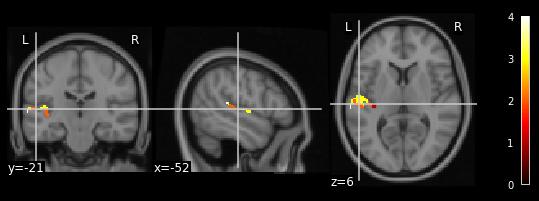

In [63]:
from nilearn import plotting
plotting.plot_stat_map(st_l, T1)

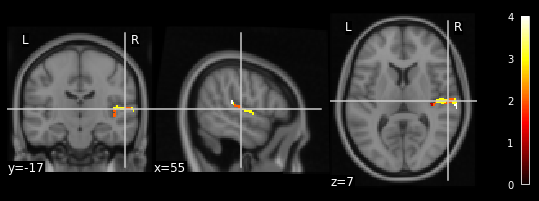

In [44]:
plotting.plot_stat_map(st_r, T1)

In [45]:
help(plotting.plot_stat_map
    )

Help on function plot_stat_map in module nilearn.plotting.img_plotting:

plot_stat_map(stat_map_img, bg_img=<MNI152Template>, cut_coords=None, output_file=None, display_mode='ortho', colorbar=True, cbar_tick_format='%.2g', figure=None, axes=None, title=None, threshold=1e-06, annotate=True, draw_cross=True, black_bg='auto', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x13ae81e80>, symmetric_cbar='auto', dim='auto', vmax=None, resampling_interpolation='continuous', **kwargs)
    Plot cuts of an ROI/mask image (by default 3 cuts: Frontal, Axial, and
    Lateral)
    
    Parameters
    ----------
    stat_map_img : Niimg-like object
        See :ref:`extracting_data`.
        The statistical map image
    
    bg_img : Niimg-like object, optional
        See :ref:`extracting_data`.
        The background image to plot on top of.
        If nothing is specified, the MNI152 template will be used.
        To turn off background image, just pass "bg_img=None".
        Default=MN

In [ ]:
nilearn.plotting.plot_stat_map(stat_map_img, bg_img